# D213 Advanced Data Analytics
# Task 1: Time Series Modeling


Petra I Bier

Western Governors University

D213 Advanced Data Analytics

January 15, 2025

Dr. William Sewell PhD

------------------------------


## Table of Contents
* [Part I **Question**](#Part-I-Question)
    - [A1: Research Question](#A1:-Research-Question)
    - [A2: Goal](#A2:-Goal)
* [Part II **Assumptions**](#Part-II-Assumptions)
    - [B1: Assumptions](#B1:-Assumptions)
* [Part III **Data Preparation**](#Part-III-Data-Preparation)
    - [C1: Line Graph](#C1:-Line-Graph)
    - [C2: Formatting](#C2:-Formatting)
    - [C3: Stationarity](#C3:-Stationarity)
    - [C4: Data Preparation](#C4:-Data-Preparation)
    - [C5: Clean Data Set](#C5:-Clean-Data-Set)
* [Part IV **Analysis**](#Part-IV-Analysis)
    - [D1: Findings and Visualizations](#D1:-Findings-and-Visualizations)
	- [D2: ARIMA Model](#D2:-ARIMA-Model)
    - [D3: Forecasting](#D3:-Forecasting)
    - [D4: Calculations and Output](#D4:-Calculations-and-Output)
    - [D5: Code](#D5:-Code)
* [Part V **Summary**](#Part-V-Summary)
    - [E1: Results](#E1:-Results)
    - [E2: Visualizations](#E2:-Visualizations)
    - [E3: Recommendations](#E3:-Recommendations)
* [Part VI **Reporting**](#Part-VI-Reporting)
	- [F1: Report](#F1:-Report)
    - [G1: Web sources](#G1:-Web-sources)
    - [H1: Sources](#H1:-Sources)

## Part I Question
---------------------------------------



### A1: Research Question
Can hospital revenue for the next quarter be predicted using two years of time series data spanning the range of January 2022 to December 2023?

### A2: Goal
This analysis aims to build an accurate time series model for forecasting hospital revenue for the next fiscal quarter. Accurate revenue predictions would enable data-driven decisions concerning staffing and resource allocation. Identified financial trends may enable management to be proactive in responding to community needs.



## Part II Assumptions
----------------

### B1: Assumptions
Several assumptions must be met for an accurate time series model. These include stationarity, no outliers, no correlation of errors, and autocorrelation (Lani, 2025).
- Stationarity: The statistical properties of the time series data are constant and do not change over time. The variance, mean, and autocorrelation are not dependent on the time variable.
- No outliers: The presence of outliers in a time series will strongly influence the results, making them misleading.
- Random error: Errors are randomly distributed, and the mean of the errors remains at zero.
- Autocorrelation: The relationship between the sequential points remains consistent and does not change over time.


## Part III Data Preparation
---------------------------------

In [1]:
# Set up of notebook
import pandas as pd # used to create the dataframe
import numpy as np  #Required dependency for scikit.learn to run
import matplotlib.pyplot as plt # to visualize the data
import matplotlib.dates as mdates
from datetime import datetime # convert to a date time series
from statsmodels.tsa.seasonal import seasonal_decompose # look for seasonality in the data
from statsmodels.tsa.stattools import adfuller # to run the augmented dicky- fuller test (ADF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # To creat ACF and PACF plots
from typing import Union
from tqdm import tqdm
from itertools import product
from pmdarima import auto_arima # to run the auto ARIMA to find the best values
from statsmodels.tsa.arima.model import ARIMA # to run an ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX # to run the suggested SARIMAX model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # to evaluate models based on error
import warnings # Ignore harmless warnings
warnings.filterwarnings("ignore")

# Visualizations within notebook https://wgu.webex.com/meet/dr.william.sewell
%matplotlib inline


In [2]:
df_time = pd.read_csv('/Users/petrabier/Desktop/WGU/D213/D213_pt1/medical_time_series .csv')
df_time.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [3]:
# Change the data into Dates, drop the Day column

df_time["Date"] = pd.date_range(start = datetime(2023, 1,1),
                               periods = df_time.shape[0], freq="24H")

df_time.set_index("Date", inplace= True)
df_time = df_time.drop("Day", axis=1)
df_time

,Revenue
Date,
2023-01-01,0.000000
2023-01-02,-0.292356
2023-01-03,-0.327772
2023-01-04,-0.339987
2023-01-05,-0.124888
...,...
2024-12-27,15.722056
2024-12-28,15.865822
2024-12-29,15.708988


In [4]:
# View information about data frame
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [5]:
#Check for null values
df_time.isna().sum()

Revenue    0
dtype: int64

In [6]:
## Find duplicates
print(df_time.duplicated().value_counts()) # this gives a count of unique values (this case is true/false)
print(df_time.duplicated().sum()) # This gives a count of the number of duplicates(counting the true)

False    731
Name: count, dtype: int64
0


### C1: Line Graph
The time series was plotted to visualize the realization of the data.


Text(0, 0.5, 'Revenue in Millions USD')

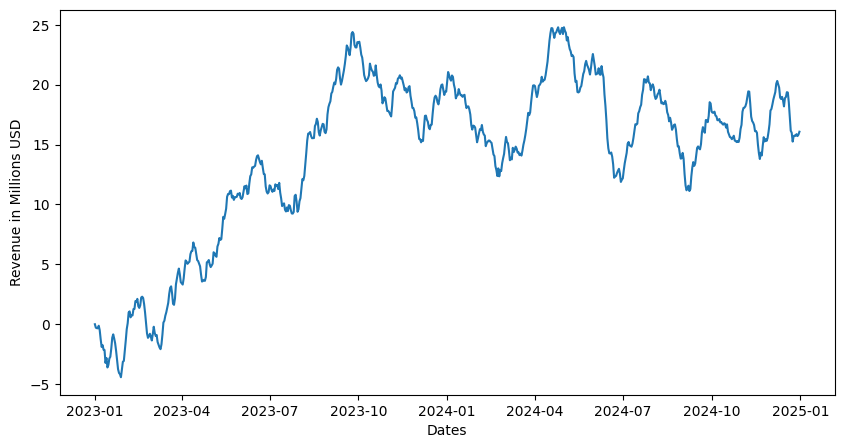

In [7]:
plt.figure(figsize = (10, 5))
plt.plot(df_time)
plt.xlabel('Dates')
plt.ylabel('Revenue in Millions USD')

### C2: Formatting
The format of the time column was originally a number count of the dates, which was changed to dates. The final format of the date column was Year-Month-Day (YYYY-MM-DD). This time covers 731 days, the two years between 2023-01-01 and 2024-12-31, as it ranges over a leap year in 2024.

In [8]:
print(f"Date range: {df_time.index[0]} to {df_time.index[-1]}")

Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00


There are 731 rows and 2 columns.

In [9]:
df_time.shape

(731, 1)

The time series realization includeds observations recorded on a daily basis.

In [10]:
#Verify no gaps and everything is in order by date
print(df_time.index.to_series().diff().value_counts())

Date
1 days    730
Name: count, dtype: int64


The size of the time period is consistent, and it is ordered chronologically in the time column.

In [11]:
#Check that the days are ordered
print(df_time.index.is_monotonic_increasing)

True


In [12]:
print(df_time.index.to_series().diff().value_counts().sort_index())

Date
1 days    730
Name: count, dtype: int64


### C3: Stationarity
The data was evaluated to determine if it was stationary. A plot was created to determine if a trend was present. The plot revealed an upward trend over time, indicating that the data is non-stationary.

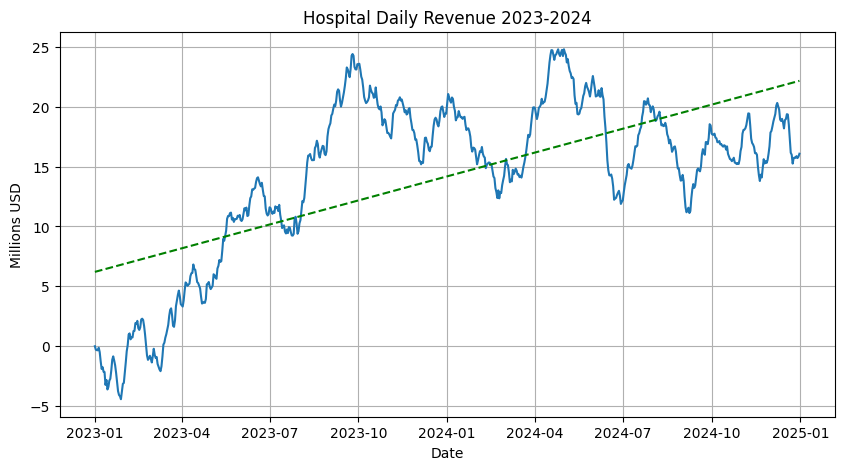

In [13]:
# Plot the data to visualize possible trends
plt.figure(figsize = (10, 5))
plt.plot(df_time.Revenue)
plt.title("Hospital Daily Revenue 2023-2024")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.grid(True)
# Generate trend line
x = mdates.date2num(df_time.index)
y = df_time.Revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot trendline
plt.plot(x, p(x), "g--")
plt.show()

An Augmented Dickey-Fuller (ADF) test was performed to numerically confirm non-stationarity. The ADF test gives two significant results that can be used to determine stationarity – the p-value and the ADF statistic. If the p-value is less than 0.05 then:
* H0- The time series data has a root unit, so it is non-stationary.
	* Reject null hypothesis if p <= 0.05
* H1 - The time series data does not have a root unit, so it is considered stationary
	* Fail to reject H0 if p >= 0.05

The second value of importance is the ADF statistic, with larger negative values indicating a greater rejection of the null hypothesis (Perktold et al., 2025).


In [14]:
#Create ADF function
def adf_test(df):
    result = adfuller(df)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Number of lags used:", result[2])
    print("Number of observations used:", result[3])
    print("Critical values:", result[4])

#Run ADF Test
adf_test(df_time)

ADF Statistic: -2.218319047608946
p-value: 0.19966400615064328
Number of lags used: 1
Number of observations used: 729
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


The results indicate the data is non-stationary due to a p-value greater than 0.05 and a slight negative ADF statistic. To achieve stationarity, the data will have to be detrended by differencing the data frame, and the ADF will have to be run on the differenced data set.

In [15]:
# First-order differencing
df_station_d1 = df_time.iloc[:,0].diff().dropna()

In [16]:
#Re-run the ADF test to see if stationarity has been achieved
adf_test(df_station_d1)

ADF Statistic: -17.374772303557066
p-value: 5.113206978840171e-30
Number of lags used: 0
Number of observations used: 729
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


The ADF results with the differenced data had a p-value less than 0.05 and a large negative number, indicating that the data set was stationary. With stationarity achieved, the order of differencing for the ARIMA model will be one since it was differenced a single time (Lewinson, 2020).

 ### C4: Data Preparation
Pre-processing and cleaning of the data for this analysis included several steps:

* Loading the data as a Pandas data frame.
* Format of the 'Day' column was changed from numeric to 'Date', including renaming of the column.
* Examined for duplicates and null values to ensure the data is clean.
    - The  cleaning code can be found [here](#Part-III-Data-Preparation)
* Verified no gaps in the time series and uniform lags size.
    - Step format verification code can be found [here](#C2:-Formatting)
* Checked for stationarity.
    - Differenced the data one order to achieve stationarity based on ADF results.
* Split original (non-differenced) data into train and test sets at 80/20 ratio

In [17]:
#Split data - Original cleaned non-stationary data
# Calculate the split point (80% of the data)
split_point = int(len(df_time) * 0.8)

# Create the train and test sets
train = df_time.iloc[:split_point]
test = df_time.iloc[split_point:]

In [18]:
# Verify the split
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Training data from {train.index[0]} to {train.index[-1]}")
print(f"Test data from {test.index[0]} to {test.index[-1]}")

Training set size: 584
Test set size: 147
Training data from 2023-01-01 00:00:00 to 2024-08-06 00:00:00
Test data from 2024-08-07 00:00:00 to 2024-12-31 00:00:00


In [19]:
#Save the cleaned data sets to CSV files
train.to_csv('D213_train.csv')
test.to_csv('D213_test.csv')

### C5: Clean Data Set
A copy of the cleaned train and test data is attached to the Performance assessment labeled as D213_train.csv and D213_test.csv.

## Part IV Analysis
--------------

### D1: Findings and Visualizations
In order to find the seasonality effects and trends, the data had to be decomposed. This process separates the time series into its trend, seasonal, and residual components (Seabold et al., 2010).

In [20]:
# Decomposition of data to find trends and seasonality
decomposition = seasonal_decompose(df_time["Revenue"], model='additive')

#### Seasonal Component


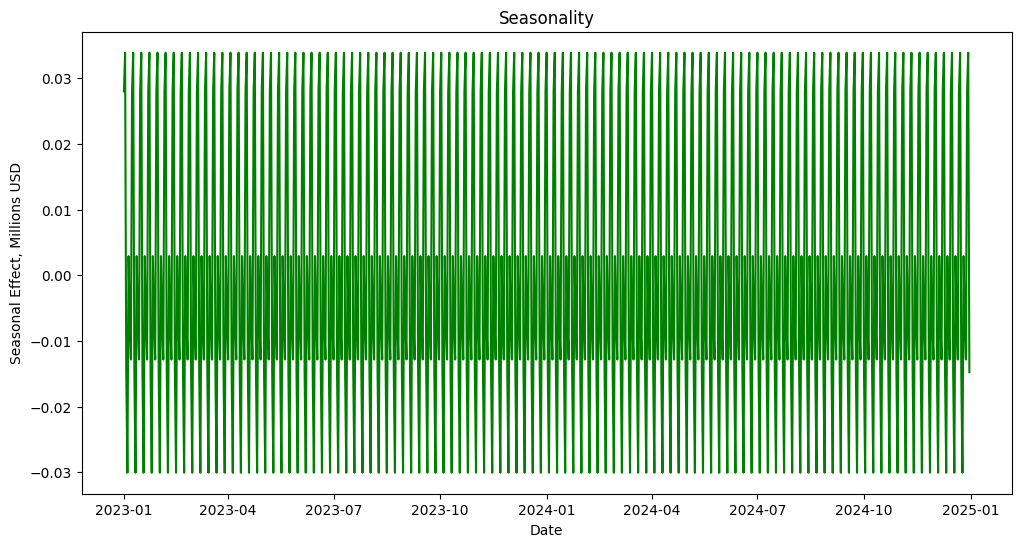

In [21]:
plt.figure(figsize=(12, 6))
plt.title("Seasonality")
plt.xlabel("Date")
plt.ylabel("Seasonal Effect, Millions USD")
plt.plot(decomposition.seasonal, color='green')
plt.show()

The seasonal component with the resulting graph showed a repeating pattern, although it did not appear sinusoidal in nature, which would indicate seasonality. A plot to investigate seasonality further was created.

Text(0, 0.5, 'Seasonal Effect, Millions USD')

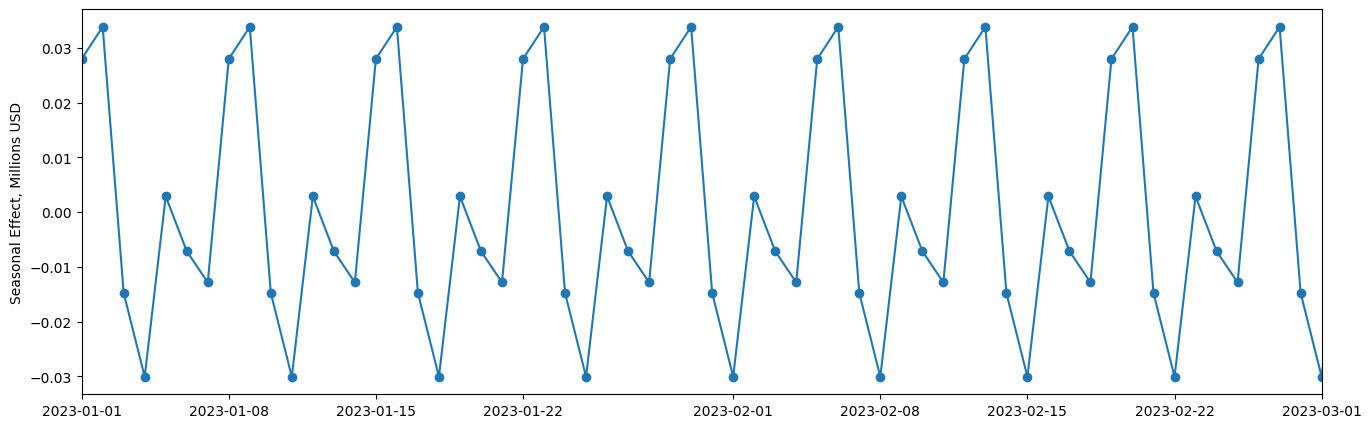

In [22]:
# Graph a smaller time period to determine if seasonality exists
plt.figure(figsize = [16,5])
plt.plot(decomposition.seasonal, marker='o')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-03-01'))
plt.ylabel("Seasonal Effect, Millions USD")

This plot confirms a pattern with multiple peaks rather than a sinusoidal pattern, indicating that the data does not have a seasonal component.

#### Trend Component
The decomposition shows an overall upward trend in the data. This is expected since the decomposition was run on the original data, which revealed an upward trend during the initial exploration of the data set.

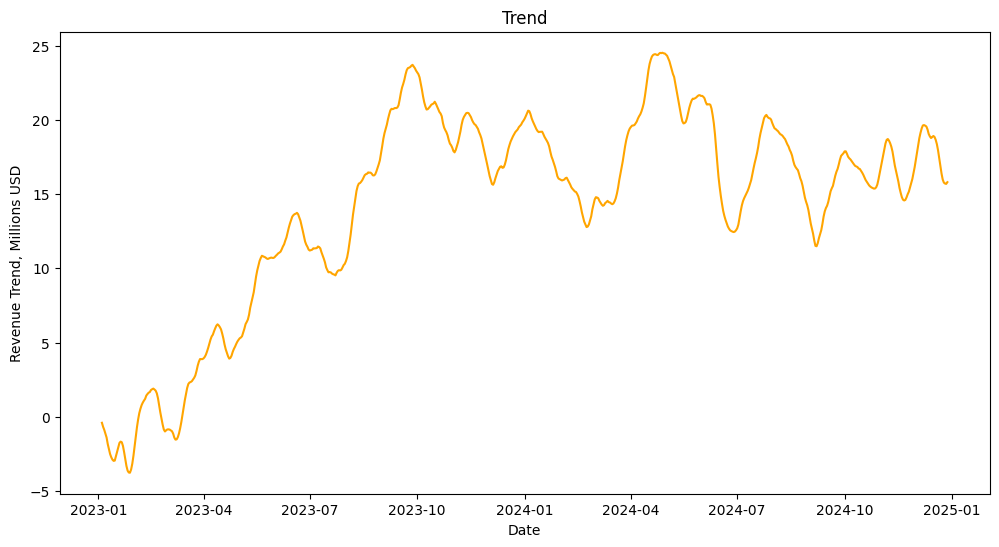

In [23]:
plt.figure(figsize=(12, 6))
plt.title("Trend")
plt.plot(decomposition.trend, color='orange')
plt.xlabel("Date")
plt.ylabel("Revenue Trend, Millions USD")
plt.show()

#### Autocorrelation
Both an Autocorrelation Function(AFC and a Partial Auto Correlation Function (PAFC) were run on the differenced data.

<Figure size 1200x600 with 0 Axes>

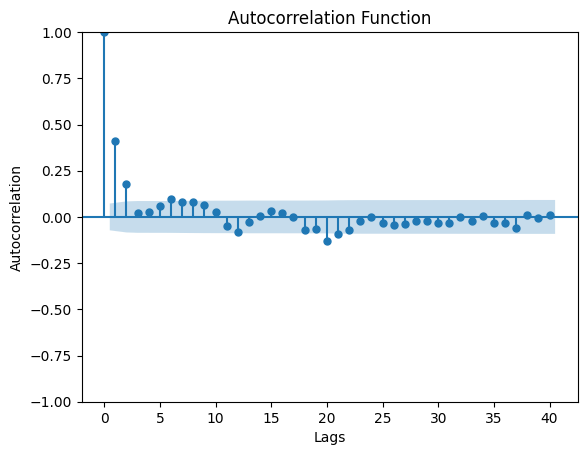

In [24]:
# ACF with differenced data
plt.figure(figsize=(12, 6))
plot_acf(df_station_d1, lags=40)
plt.title("Autocorrelation Function")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

#### ACF Interpretation
The AFC function allows us to determine the moving average MA(q) component of an ARIMA model. The ACF shows a count of 2 significant lags, which suggests that the q value should be at 2 (Peixeiro, 2022, pp. 69). This value will be used for the MA(q) when building a manual ARIMA model.

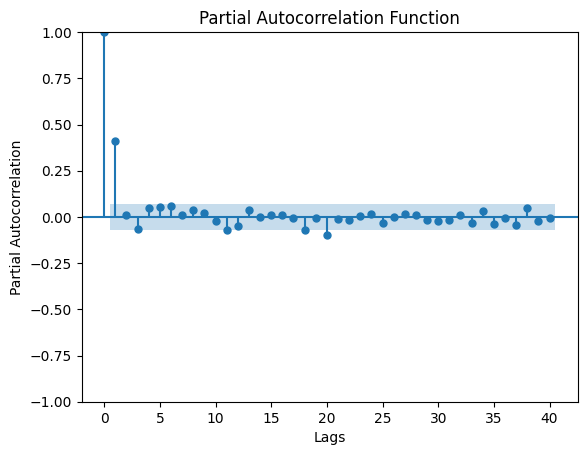

In [25]:
# Plot PACF with differenced data
plot_pacf(df_station_d1, lags=40)
plt.title("Partial Autocorrelation Function")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

#### PACF Intepretation
The PACF lets us determine the autoregressive component of the ARIMA model, AR(p) (Peixeiro, 2022, pp. 90). The plot shows the first lag has the strongest correlation, so the AR(q) will have an order of 1 when building a manual ARIMA model.

#### Spectral Analysis
A spectral analysis was also run on the differenced data in order to assess the series for seasonality. The resulting plot revealed no patterns indicating no seasonality in the data.

(array([0.32257506, 0.40884703, 0.49108501, 0.59363947, 0.44995182,
        0.43635387, 0.5357234 , 0.16305364, 0.34293175, 0.41847817,
        0.1854376 , 0.38567299, 0.39874179, 0.1799679 , 0.17853729,
        0.28365529, 0.1610269 , 0.10640454, 0.53767765, 0.46046065,
        0.11950937, 0.19963337, 0.36416991, 0.26380782, 0.1623704 ,
        0.15866557, 0.08052751, 0.40736853, 0.22936871, 0.22299038,
        0.8777625 , 0.48053998, 0.42173172, 0.38112086, 0.98119354,
        0.35808748, 0.15519901, 0.39425909, 0.36036735, 0.25216393,
        0.2264646 , 0.08593259, 0.15464965, 0.19248573, 0.22499538,
        0.67046396, 0.55864956, 0.255673  , 0.1297722 , 0.18896368,
        0.27492621, 0.17285359, 0.24883683, 0.20734247, 0.14470371,
        0.1810512 , 0.01763434, 0.11846138, 0.14886074, 0.03217488,
        0.08328853, 0.15081611, 0.16255357, 0.1569423 , 0.19494704,
        0.15886441, 0.09868138, 0.04977481, 0.07095888, 0.09345138,
        0.08781674, 0.03171429, 0.06113389, 0.14

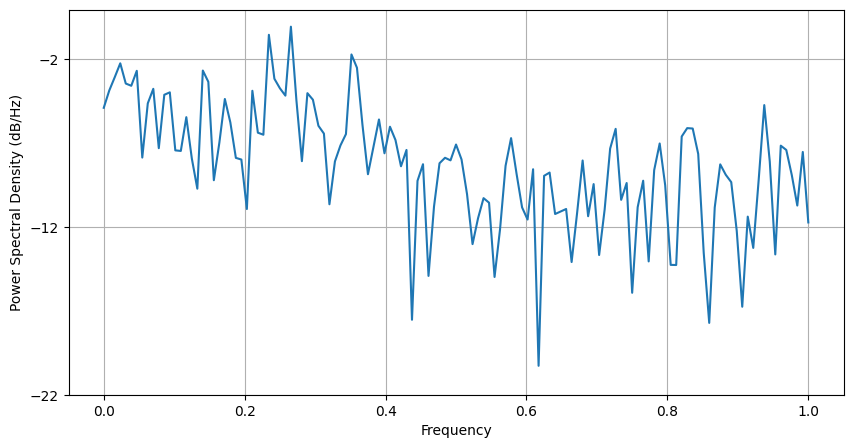

In [26]:
#spectral analysis
plt.figure(figsize=(10,5), linewidth=3)
plt.psd(df_station_d1)

#### Decomposed Time Series
The decomposed data was plotted into its separate components.

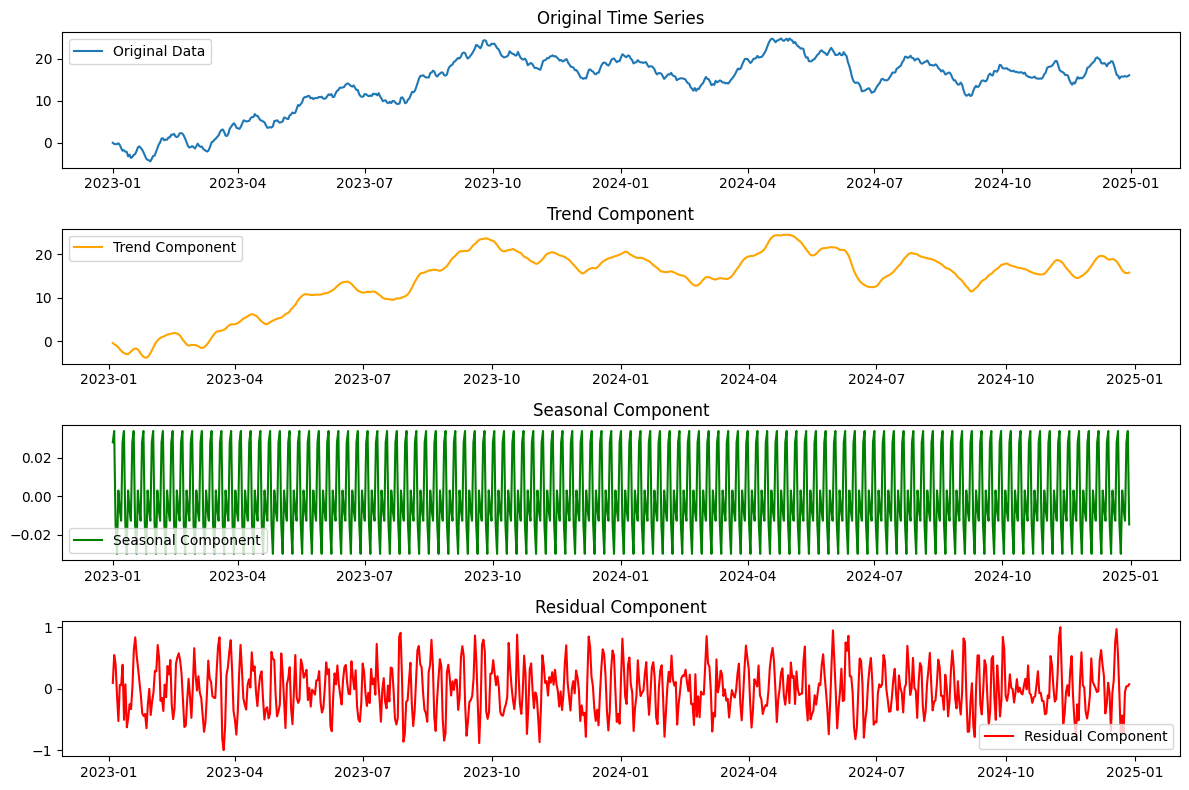

In [27]:
# Plot the decomposed components

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df_time["Revenue"], label="Original Data")
plt.title("Original Time Series")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend Component", color="orange")
plt.title("Trend Component")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonal Component", color="green")
plt.title("Seasonal Component")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual Component", color="red")
plt.title("Residual Component")
plt.legend()

plt.tight_layout()
plt.show()

#### Decomposed Residuals
The residuals of the decomposed data are all centered around zero and have no noticeable pattern, indicating that the errors are random and not correlated.

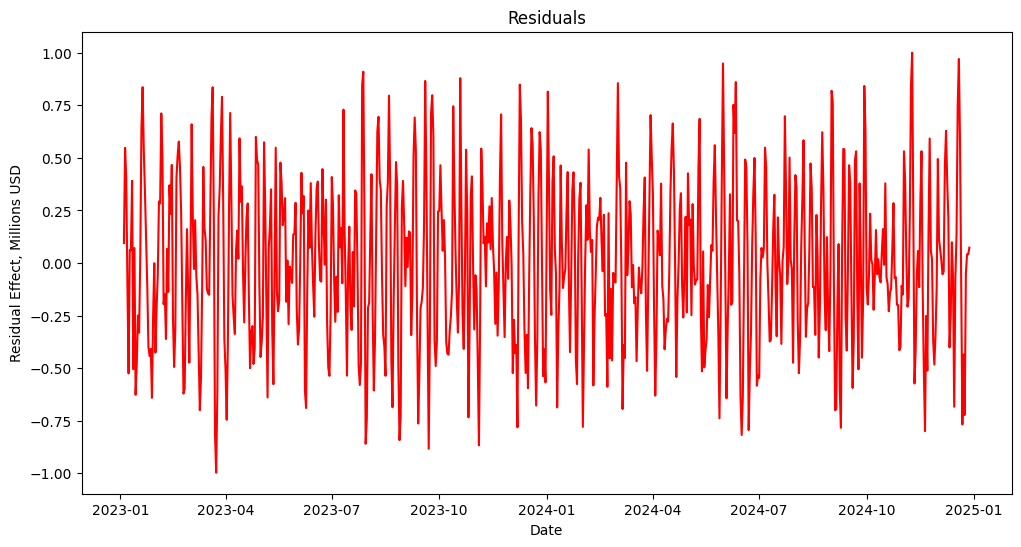

In [28]:
plt.figure(figsize=(12, 6))
plt.title("Residuals")
plt.plot(decomposition.resid, color= "red")
plt.xlabel("Date")
plt.ylabel("Residual Effect, Millions USD")
plt.show()

### D2: ARIMA Model
Three types of models were examined to determine the best approach for this analysis. The first used the auto_arima function, the second implemented multiple iterations of the SARIMA model incorporating seasonal values, and the third used values manually determined through the [PACF](#PACF-Intepretation) and [ACF](#ACF-Interpretation) plots. The models were then compared using the Akaike Information Criterion (AIC) values, with the lowest AIC determining the final selection.

#### Auto_ARIMA Function

In [29]:
# Fit auto_arima function
auto_model = auto_arima(train,
                     start_p=1, start_q=1,
                     max_p=3, max_q=3,
                     seasonal=True,
                     d=None,  # let the model determine 'd'
                     D=None,  # let the model determine 'D'
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)    # set to stepwise

# To print the summary
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=708.064, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=810.657, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=706.498, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=729.203, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=811.354, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=707.865, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=705.906, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=706.256, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=705.600, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=704.253, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=702.748, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=704.175, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=705.662, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=702.004, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=728.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -348.002
Date:                Sun, 19 Jan 2025   AIC                            702.004
Time:                        11:12:32   BIC                            715.109
Sample:                    01-01-2023   HQIC                           707.112
                         - 08-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3930      0.040      9.771      0.000       0.314       0.472
ma.L2          0.2214      0.040      5.502      0.000       0.143       0.300
sigma2         0.1931      0.012     15.809      0.000       0.169       0.217
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.89   Prob(JB):                         0.36
Heteroskedasticity (H):               1.05   Skew:                            -0.06
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This auto_ARIMA model gave  AIC results of 702 with the order of (0,1,2) and no suggestions for seasonality.

#### SARIMA Model Selection Function
A function was built to iteratively examine different model fits of the data, with several types of seasonality included (Peixeiro, 2022, pp. 168).

In [30]:
#Function to fit SARIMA model variations

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], ds, order[1]),
                seasonal_order=(order[2], Ds, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [31]:
#define the ranges to run
ps = range(0,4,1)
qs = range(0,4,1)
Ps = range(0,4,1)
Qs = range(0,4,1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

SARIMA_train = train['Revenue']

ds = 1
Ds = 1
s = 7 #seasonality component

SARIMA_results_df = optimize_SARIMA(SARIMA_train, SARIMA_order_list, ds, Ds, s)
SARIMA_results_df

100%|██████████| 256/256 [09:17<00:00,  2.18s/it]


,"(p,q,P,Q)",AIC
0,"(0, 2, 0, 1)",728.235901
1,"(0, 3, 0, 1)",729.618461
2,"(1, 2, 0, 1)",729.717333
3,"(0, 2, 1, 1)",729.876007
4,"(0, 2, 0, 2)",729.880932
...,...,...
251,"(1, 0, 0, 0)",1084.977319
252,"(2, 0, 0, 0)",1085.008701
253,"(1, 1, 0, 0)",1085.678048
254,"(0, 1, 0, 0)",1099.644677


The SARIMA model function returned the best AIC of 728.24. The SARIMA model function does have a seasonality component, which was chosen due to the repeating pattern found during decomposition. However, the data is not actually believed to have seasonality due to the lack of a sinusoidal pattern. This was done as an exercise to verify that a seasonal model would not perform better.

#### Manual ARIMA model
The manual model was built with an AR(p) of 1 based on the number of significant lags observed from the PACF. The I(d) value was 1 since the data was differenced a single time. The MA(q) value was 2 based on the ACF plot, revealing two significant lags.

In [32]:
#Manual ARIMA
manual_model = ARIMA(train,
              order = (1, 1, 2))

manual_result = manual_model.fit()
manual_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -347.715
Date:                Sun, 19 Jan 2025   AIC                            703.430
Time:                        11:21:49   BIC                            720.903
Sample:                    01-01-2023   HQIC                           710.241
                         - 08-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1247      0.181      0.688      0.492      -0.231       0.480
ma.L1          0.2757      0.179      1.542      0.123      -0.075       0.626
ma.L2          0.1866      0.070      2.666      0.008       0.049       0.324
sigma2         0.1929      0.012     15.670      0.000       0.169       0.217
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.98   Prob(JB):                         0.34
Heteroskedasticity (H):               1.05   Skew:                            -0.05
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### The results of the manual model show an AIC of 703.

The auto_ARIMA had the lowest AIC value and will be used as the model for the analysis

In [33]:
# Fit the data to the auto_ARIMA model
model1 = ARIMA(train,
              order = (0, 1, 2))

result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -348.002
Date:                Sun, 19 Jan 2025   AIC                            702.004
Time:                        11:21:50   BIC                            715.109
Sample:                    01-01-2023   HQIC                           707.112
                         - 08-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3930      0.040      9.771      0.000       0.314       0.472
ma.L2          0.2214      0.040      5.502      0.000       0.143       0.300
sigma2         0.1931      0.012     15.809      0.000       0.169       0.217
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.89   Prob(JB):                         0.36
Heteroskedasticity (H):               1.05   Skew:                            -0.06
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Find the model RMSE of the model
rmse_model = np.sqrt((result1.resid ** 2).mean())
rmse_model

0.4391150267092655

The Root Mean Squared Error (RMSE) metric shows that the model fitted only to the training data has an error of an average of $440,000.

<Figure size 2000x1000 with 0 Axes>

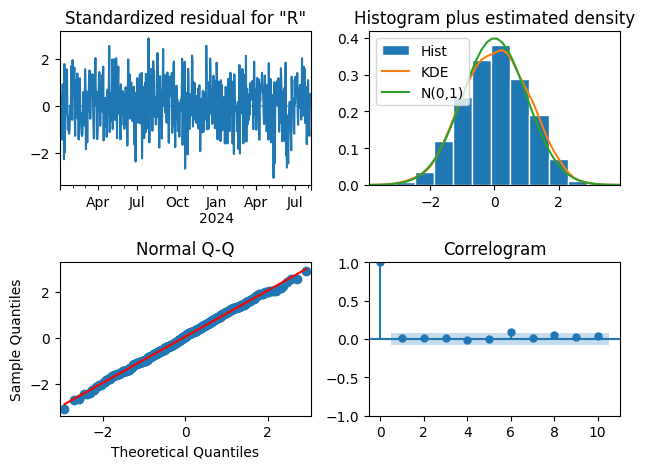

In [35]:
#Plot the diagnostic results
plt.figure(figsize=[20,10])
result1.plot_diagnostics()
plt.tight_layout()

A full explanation of diagnostic plots can be found in section [E1: Results](#E1:-Results).

### D3: Forecasting
The model had to be trained on the data to forecast future revenue. A prediction of the same length as the training data was made and the two values were compared to evaluate how well the model performed.

In [36]:
#Get predictions
start = len(train)
end = len(train) + len(test) - 1

#Predictions against the test set
predictions = result1.predict(start, end,
                             typ = 'levels').rename("Predictions")


In [37]:
print(predictions)

2024-08-07    19.307426
2024-08-08    19.348228
2024-08-09    19.348228
2024-08-10    19.348228
2024-08-11    19.348228
                ...    
2024-12-27    19.348228
2024-12-28    19.348228
2024-12-29    19.348228
2024-12-30    19.348228
2024-12-31    19.348228
Freq: D, Name: Predictions, Length: 147, dtype: float64


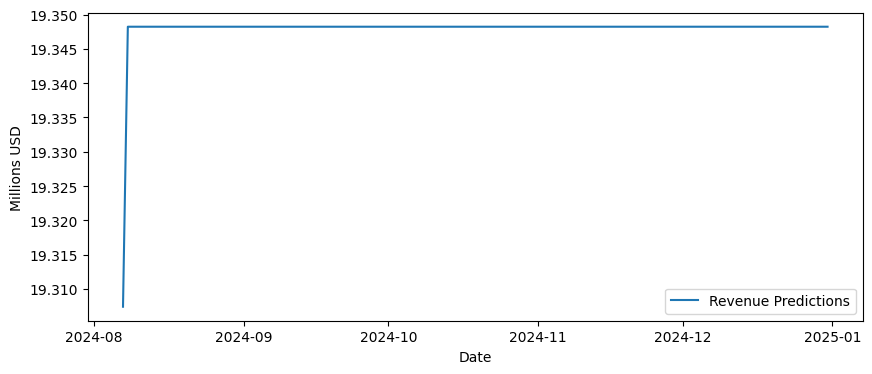

In [38]:
plt.figure(figsize=(10,4))
plt.plot(test.index, predictions, label='Revenue Predictions')
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()


The next step was to compare the predictions to the actual test data.

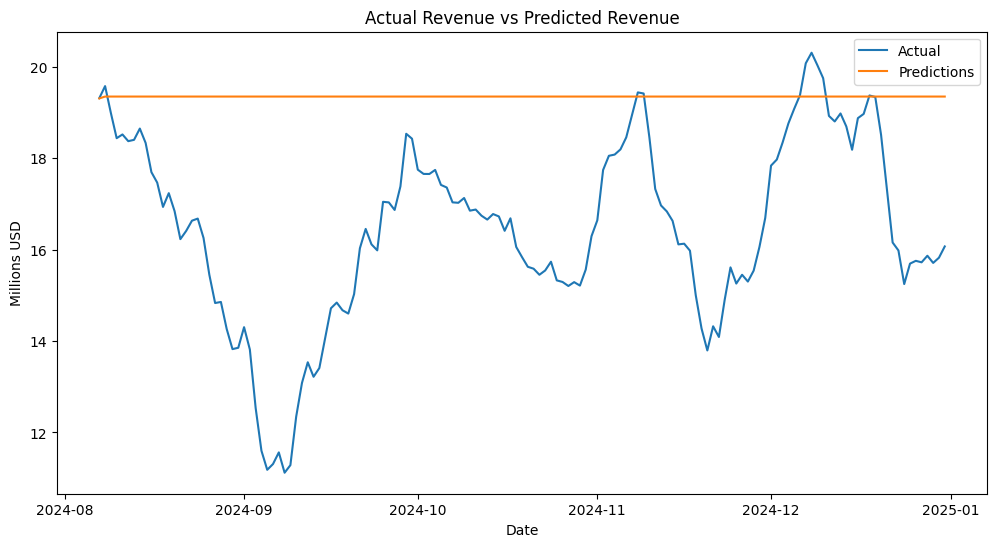

In [39]:
# Actual vs predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predictions')
plt.title("Actual Revenue vs Predicted Revenue")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()

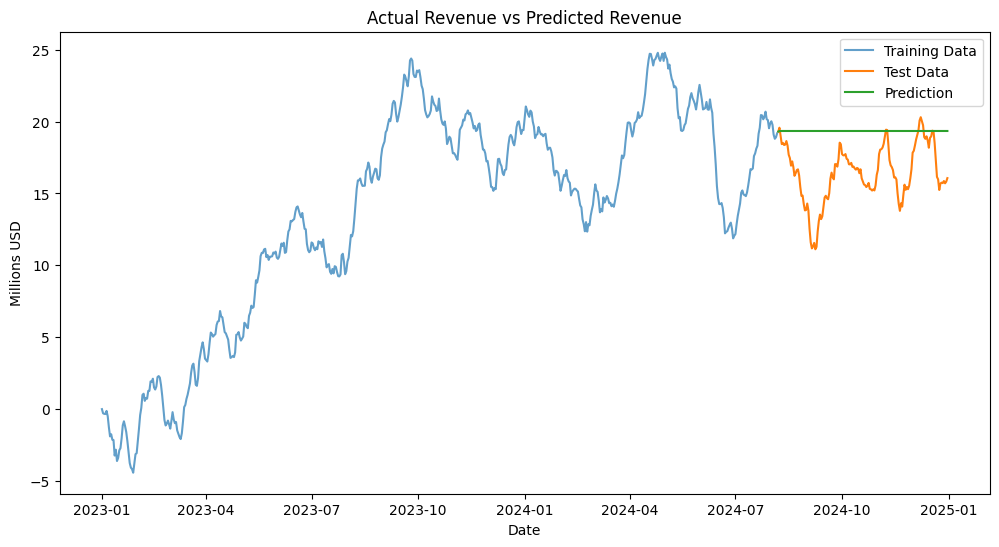

In [40]:
#Visualize predictions vs actual data using the test data as a comparison
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data', alpha=0.7)
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, predictions, label='Prediction')
#plt.fill_between(test.index, lower_limit, upper_limit, alpha=0.2, label='Confidence Interval')
plt.title("Actual Revenue vs Predicted Revenue")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()

In [41]:
# Calculate RMSE/ MSE for Predictions
rmse_predictions = np.sqrt(mean_squared_error(test["Revenue"], predictions))
#Calulate the Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(test["Revenue"], predictions)

print(f"RMSE for predictions: {rmse_predictions}")
print(f"MAPE for predictions: {mape}")

RMSE for predictions: 3.53603399231045
MAPE for predictions: 0.19900249187948904


The Root Mean Squared Error (RMSE) value of the predictions based on the model fitted to all of the data sets indicates that each prediction is off by an average of $3.53 million. This can be thought of in a percentage by using the Mean Absolute Percentage Error (MAPE) value, which tells us that each prediction is off by an average of 19.9%.

#### Create a forecast
The model was then trained on the entire data set so that a forecast could be made for one fiscal quarter (91 days) into the future.

In [42]:
# Train the model on the full dataset
full_model = ARIMA(df_time,
              order = (0, 1, 2))

full_result = full_model.fit()
full_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -436.181
Date:                Sun, 19 Jan 2025   AIC                            878.361
Time:                        11:21:50   BIC                            892.141
Sample:                    01-01-2023   HQIC                           883.678
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4080      0.036     11.475      0.000       0.338       0.478
ma.L2          0.1978      0.036      5.452      0.000       0.127       0.269
sigma2         0.1934      0.011     17.889      0.000       0.172       0.215
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.91   Prob(JB):                         0.39
Heteroskedasticity (H):               1.02   Skew:                            -0.04
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
future_index = pd.date_range(start='2024-12-31', end='2025-03-30', freq='D')
print(future_index)

DatetimeIndex(['2024-12-31', '2025-01-01', '2025-01-02', '2025-01-03',
               '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-11',
               '2025-01-12', '2025-01-13', '2025-01-14', '2025-01-15',
               '2025-01-16', '2025-01-17', '2025-01-18', '2025-01-19',
               '2025-01-20', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-25', '2025-01-26', '2025-01-27',
               '2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31',
               '2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04',
               '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-08',
               '2025-02-09', '2025-02-10', '2025-02-11', '2025-02-12',
               '2025-02-13', '2025-02-14', '2025-02-15', '2025-02-16',
               '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20',
               '2025-02-21', '2025-02-22', '2025-02-23', '2025-02-24',
      

<Axes: xlabel='Date'>

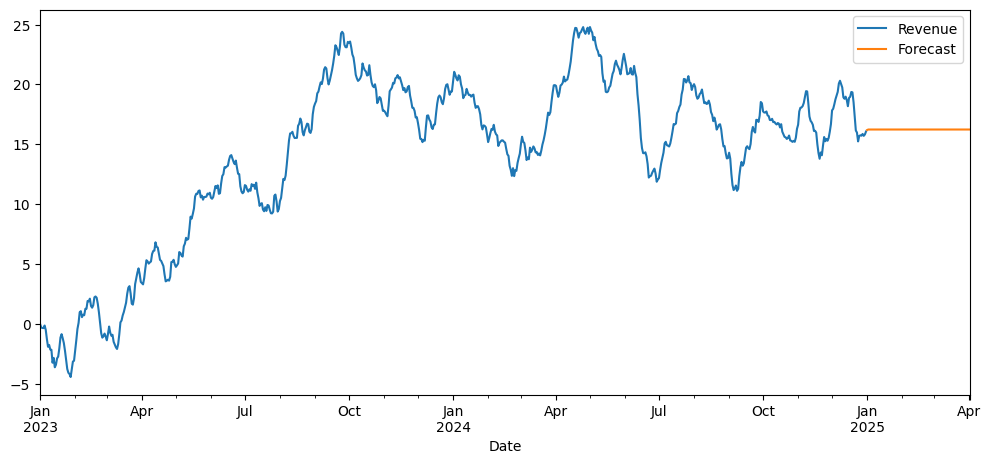

In [44]:
# Forecast for the next 3 months
# Get the last date
last_date = df_time.index[-1]
# Add 3 months worth of days
full_forecast = full_result.predict(start=len(df_time),
                        end=len(df_time) + 91,  # 91 days = exactly 13 weeks
                        typ='levels').rename('Forecast')

# Plot the forecast values
df_time["Revenue"].plot(figsize = (12, 5), legend = True)
full_forecast.plot(legend = True)


In [45]:
full_forecast.index = pd.date_range(start='2024-12-31', end='2025-04-01',)

In [46]:
print(full_forecast)

2024-12-31    16.192591
2025-01-01    16.236952
2025-01-02    16.236952
2025-01-03    16.236952
2025-01-04    16.236952
                ...    
2025-03-28    16.236952
2025-03-29    16.236952
2025-03-30    16.236952
2025-03-31    16.236952
2025-04-01    16.236952
Freq: D, Name: Forecast, Length: 92, dtype: float64


The full forecast was then plotted and compared to the test data.

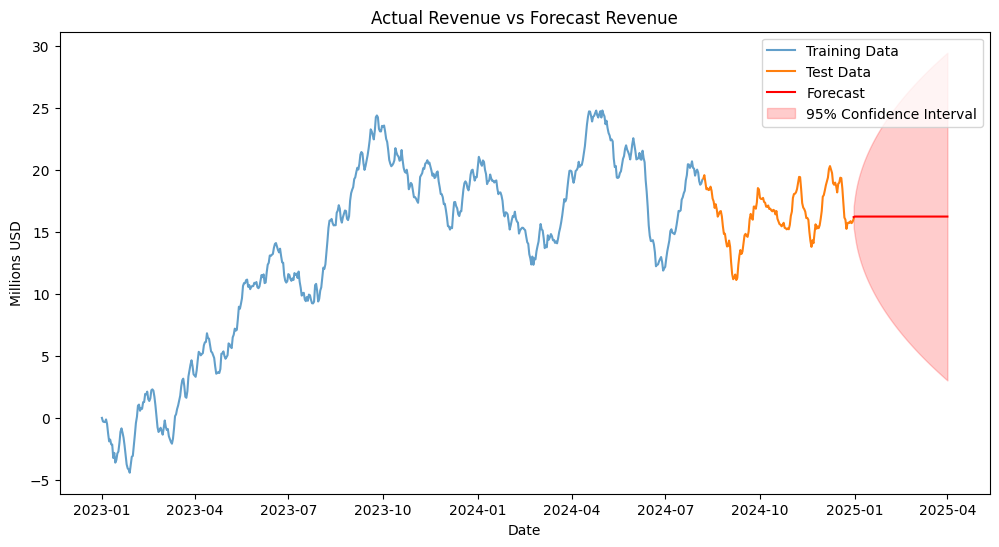

In [47]:
# Plot train, test and forcast data with the confidence interval.
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data', alpha=0.7)
plt.plot(test.index, test, label='Test Data')
plt.plot(full_forecast.index, full_forecast, label='Forecast', color='red')

# plot confidence intervals
conf_int = full_result.get_prediction(start=len(df_time),
                                    end=len(df_time) + 91).conf_int()
plt.fill_between(full_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.2,
                 color='red',
                 label='95% Confidence Interval')

plt.title("Actual Revenue vs Forecast Revenue")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()

### D4: Calculations and Output
All calculations and output are included in this presentation and shown in the above sections

### D5: Code
All code is included in the above section of this analysis.

## Part V Summary
-----------------------

### E1: Results

The ARIMA model was chosen for this analysis. No seasonality was detected when visualizing the data through both decomposition and spectral analysis, indicating that a seasonal SARIMA model would not be appropriate. This was further validated when the custom function exploring various SARIMA parameters failed to identify a model with better performance, and the auto_ARIMA function could not detect seasonality. Among the three models evaluated, the chosen ARIMA model, which does not account for seasonality, had the lowest AIC value.

The interval chosen for the forecast was a fiscal quarter, approximately 3 months. The exact number of days was 91, which is exactly 13 weeks. The data used for training was two years, so a smaller prediction time frame had to be chosen. Forecasting becomes less reliable as it moves further into the future, so a quarter is a small enough time frame to have reasonable confidence in the prediction's accuracy.


The final model was evaluated using RMSE and MAPE. The diagnostic results were also visualized.

In [48]:
# Error for full dataset model

rmse_full = np.sqrt((full_result.resid ** 2).mean())
mape_full = np.mean(np.abs(full_result.resid / df_time["Revenue"])) * 100

print(f"Full data model RMSE: {rmse_full}")
print(f"Full data model MAPE: {mape_full}%")

Full data model RMSE: 0.4394628022057179
Full data model MAPE: 7.519954974394126%


The model has an average error of $439,500 (shown by the RMSE) and predictions deviate from actual values by 7.52% on average (shown by the MAPE).

<Figure size 2000x1000 with 0 Axes>

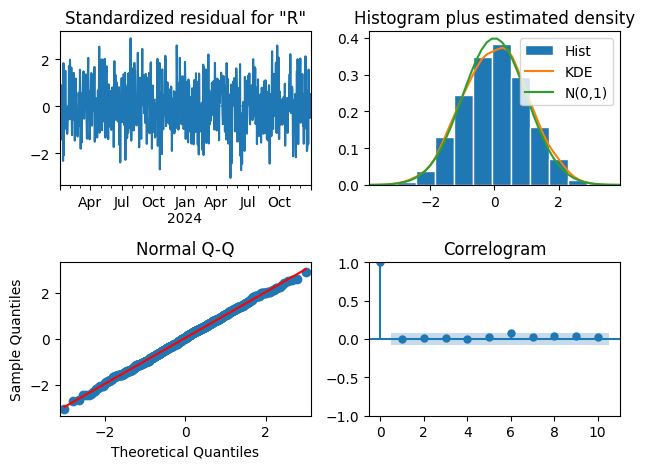

In [49]:
#Plot the diagnostic results
plt.figure(figsize=[20,10])
full_result.plot_diagnostics()
plt.tight_layout()

The visual diagnostic evaluation show several aspects regarding the model (Hosni, 2022):

(Starting in the top left and working clockwise)
* The residuals graph shows no discernible pattern; the results are evenly distributed and centered around zero. This means the model is homoscedastic and performing effectively.
* The histogram of the residuals shows that there is a normal distribution of the residuals. The orange Kernel Density Estimation (KDE) line is a smoothed version of the residual distribution, and the  green line graphs out a normal distribution. Since the two lines are similar, the model can be assumed to be good.
* The correlogram is an ACF plot of the models residuals. Since there is no significant lag correlation, the model is performing well.
* The Q-Q plot reveals the distribution of the residuals, which should all fall along the red line. This plot shows that the residuals have a normal distribution, again indicating that the model is performing adequately.

### E2: Visualizations
The future predictions were plotted against the training and test data, and a confidence interval was added to the plot.

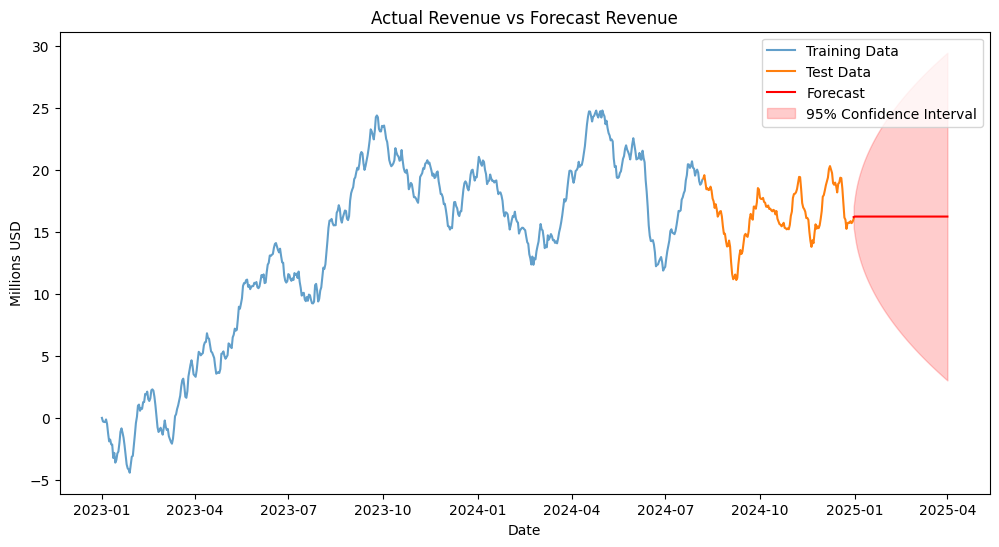

In [50]:
# Plot train, test and forcast data with the confidence interval.T
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data', alpha=0.7)
plt.plot(test.index, test, label='Test Data')
plt.plot(full_forecast.index, full_forecast, label='Forecast', color='red')

# plot confidence intervals
conf_int = full_result.get_prediction(start=len(df_time),
                                    end=len(df_time) + 91).conf_int()
plt.fill_between(full_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.2,
                 color='red',
                 label='95% Confidence Interval')

plt.title("Actual Revenue vs Forecast Revenue")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()

### E3: Recommendations
The results of this analysis show a model with moderate error but a large confidence interval, rendering the practicality of using the predictions unusable. Any business decisions based on this prediction model run the risk of causing losses for the hospital. Hospital revenue has been shown to have seasonality (Clements, 2019). This pattern is notably absent in this dataset, raising additional concerns.

Recommendations include:

* Separate the data into distinct revenue streams such as in-patient, out-patient services, and day surgery, allowing for targeted predictions for each line of service.
* Data from different locales should be analyzed separately to account for local demographic differences.
* Incorporate the payer mix data for each hospital to understand how payment types affect revenue in-flow.

More comprehensive data should be collected and alternative models developed before basing any financial decisions on future predictions. Due to the large confidence interval, prediction time frames should be decreased. Overall, the model from this analysis in not recommended as a basis for making future financial decisions.

## Part VI Reporting
---------------------

### F1: Report
This report is submitted as a jupyter notebook in .ipynb, PDF, and HTML format.


### G1: Web sources

Clements, J. (2019, April 10). Managing the Impact of Seasonality on the Healthcare Revenue Cycle. Outsource Stratgies International. Retrieved January 15, 2025, from https://www.outsourcestrategies.com/blog/managing-impact-of-seasonality-on-healthcare-revenue-cycle/

Hosni, Y. (2022, May 12). Time Series Forecasting with ARIMA Models In Python [Part 2]. Towards AI. Retrieved January 15, 2025, from https://towardsai.net/p/l/time-series-forecasting-with-arima-models-in-python-part-2

Lani, J. (2025). Time Series Analysis. Intellectus Consulting. Retrieved January 5, 2025, from https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/time-series-analysis/

Lewinson, E. (2020). An intuitive guide to differencing time series in Python. Towards Data Science. Retrieved January 10, 2025, from https://towardsdatascience.com/an-intuitive-guide-to-differencing-time-series-in-python-1d6c7a2c067a

Seabold, S., Perktold, J., & Taylor, J. (2010-2025). statsmodels: Econometric and statistical modeling with python [Software package]. https://www.statsmodels.org/


### H1: Sources

Peixeiro, M. (2022). Time Series Forecasting in Python (pp. 69, 90). Manning.